In [1]:
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

from pipeline import Dataset

dataset = Dataset.load()
m_agg_df = pd.concat([
    dataset.market.set_index('timeslot').loc[1].set_index(['asset', 'day'])['open'],
    dataset.market.set_index('timeslot').loc[50].set_index(['asset', 'day'])['close'],
    dataset.market.groupby(['asset', 'day']).agg(high=('high', max), low=('low', min), var=('close', np.std),
                                                 avg=('close', np.mean), volume=('volume', np.sum),
                                                 money=('money', np.sum)),
], axis=1)
full_df = pd.concat(
    [m_agg_df, dataset.fundamental.set_index(['asset', 'day']), dataset.ref_return.set_index(['asset', 'day'])],
    axis=1).dropna()


# construct feature
def get_single_day_return(s):
    return (s.shift(-1) / s - 1).fillna(0)


wdf = dataset.market.groupby(by='asset').apply(
    lambda df: get_single_day_return(df.set_index('timeslot').loc[50].set_index('day')['close']))
hold_1_return = wdf.reset_index().melt(id_vars=['asset'], value_vars=wdf.columns,
                                       value_name='hold_1_return').sort_values(by=['asset', 'day']).reset_index(
    drop=True)
day_before_hold_1_return = hold_1_return.set_index(['asset', 'day']).groupby(level=0).shift(1, fill_value=0)
full_df['hold_1_return'] = hold_1_return.set_index(['asset', 'day'])
full_df['day_before_hold_1_return'] = day_before_hold_1_return

In [30]:
df = full_df.copy()

df['log_close'] = np.log(full_df['close']).replace([np.inf, -np.inf], np.nan).ffill()
df['log_var'] = np.log(full_df['var']).replace([np.inf, -np.inf], np.nan).ffill()
df['log_volume'] = np.log(full_df['volume']).replace([np.inf, -np.inf], np.nan).ffill()
df['log_turnoverRatio'] = np.log(full_df['turnoverRatio']).replace([np.inf, -np.inf], np.nan).ffill()
df['log_money'] = np.log(full_df['money']).replace([np.inf, -np.inf], np.nan).ffill()
df['log_transactionAmount'] = np.log(full_df['transactionAmount']).replace([np.inf, -np.inf], np.nan).ffill()

df['pe'] = full_df['pe'].clip(upper=full_df['pe'].quantile(0.9))
df['pe_ttm'] = full_df['pe_ttm'].clip(upper=full_df['pe'].quantile(0.9))
df['pcf'] = full_df['pcf'].clip(lower=full_df['pcf'].quantile(0.1), upper=full_df['pe'].quantile(0.9))
df['log_pb'] = np.log(full_df['pb']).replace([np.inf, -np.inf], np.nan).ffill()
df['log_ps'] = np.log(full_df['ps']).replace([np.inf, -np.inf], np.nan).ffill()

df_swap = df.swaplevel().sort_index()

/opt/miniconda3/envs/qids-2023-comp/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/qids-2023-comp/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/qids-2023-comp/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [37]:
X = df_swap[['day_before_hold_1_return', 'log_close',
       'log_var', 'log_volume', 'log_turnoverRatio', 'log_money',
       'log_transactionAmount', 'log_pb', 'log_ps']]
# X = full_df[['day_before_hold_1_return']]
y = df_swap['return']

tscv = TimeSeriesSplit(n_splits=5)
for train, test in tscv.split(df_swap):
    reg = LinearRegression().fit(X.iloc[train], y.iloc[train])
    train_score = reg.score(X.iloc[train], y.iloc[train])
    test_score = reg.score(X.iloc[test], y.iloc[test])
    print(f'train score: {train_score:.4f}, test score: {test_score:.4f}')

final_model = LinearRegression().fit(X, y)

train score: 0.0256, test score: -0.0390
train score: 0.0148, test score: -0.0672
train score: 0.0098, test score: -0.0219
train score: 0.0074, test score: -0.0139
train score: 0.0063, test score: -0.0027


In [32]:
df_swap.columns

Index(['open', 'close', 'high', 'low', 'var', 'avg', 'volume', 'money',
       'turnoverRatio', 'transactionAmount', 'pe_ttm', 'pe', 'pb', 'ps', 'pcf',
       'return', 'hold_1_return', 'day_before_hold_1_return', 'log_close',
       'log_var', 'log_volume', 'log_turnoverRatio', 'log_money',
       'log_transactionAmount', 'log_pb', 'log_ps'],
      dtype='object')

<AxesSubplot: xlabel='pcf', ylabel='return'>

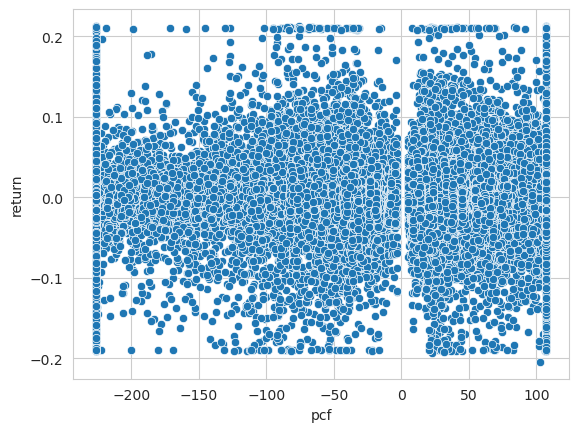

In [31]:
sns.scatterplot(data=df_swap, x='pcf', y='return')

In [38]:
from pandas.plotting import lag_plot, autocorrelation_plot

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

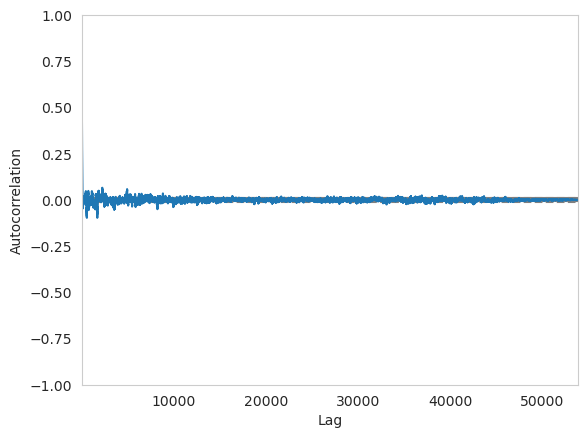

In [39]:
autocorrelation_plot(df['hold_1_return'])